參考:
1.	https://keras.io/examples/vision/image_classification_efficientnet_fine_tuning/
2.	https://colab.research.google.com/github/Tony607/efficientnet_keras_transfer_learning/blob/master/Keras_efficientnet_transfer_learning.ipynb#scrollTo=SmzQmZdKDfSF


In [ ]:
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import optimizers
import os
import glob
import shutil
import sys
import numpy as np
from skimage.io import imread
import matplotlib.pyplot as plt
from IPython.display import Image
%matplotlib inline

## batch size、image size
減少batch size有助於提高validation accuracy

放大image size也會讓模型表現更加

In [ ]:
batch_size = 32

width = 448
height = 448
epochs = 20
dropout_rate = 0.2
input_shape = (height, width, 3)

In [ ]:
# Options: EfficientNetB0, EfficientNetB1, EfficientNetB2, EfficientNetB3
# Higher the number, the more complex the model is.
from tensorflow.keras.applications import EfficientNetB0 as Net

## 使用effecientnet作為pretrain model

In [ ]:
# loading pretrained conv base model
conv_base = Net(weights='imagenet', include_top=False, input_shape=input_shape)

In [ ]:
import numpy as np 
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import shutil
#os.mkdir('/content/drive/MyDrive/碩一上/作業/基於深度學習之視覺辨識/HW1/train')

class_path = '/content/drive/MyDrive/碩一上/作業/基於深度學習之視覺辨識/HW1/classes.txt'
with open(class_path) as f:
  classes = [x.strip() for x in f.readlines()]  # all the testing images

#for i in classes:
#  os.mkdir('/content/drive/MyDrive/碩一上/作業/基於深度學習之視覺辨識/HW1/train/'+i[0:3])

In [ ]:
BASE_DIR = '/content/drive/MyDrive/碩一上/作業/基於深度學習之視覺辨識/HW1/new_split'
print('BASE_DIR contains ', os.listdir(BASE_DIR))
TRAIN_DIR = os.path.join(BASE_DIR, 'train')
VALIDATION_DIR = os.path.join(BASE_DIR, 'val')
print(len(os.listdir(TRAIN_DIR)))
print(len(os.listdir(VALIDATION_DIR)))

BASE_DIR contains  ['train', 'val']
200
200


## 資料擴增
因為原本的資料太少了 每個類別都只有15張圖片

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')

# Note that the validation data should not be augmented!
test_datagen = ImageDataGenerator()

train_generator = train_datagen.flow_from_directory(
        # This is the target directory
        TRAIN_DIR,
        # All images will be resized to target height and width.
        target_size=(height, width),
        batch_size=batch_size,
        # Since we use categorical_crossentropy loss, we need categorical labels
        class_mode='categorical')

validation_generator = test_datagen.flow_from_directory(
        VALIDATION_DIR,
        target_size=(height, width),
        batch_size=batch_size,
        class_mode='categorical')

Found 2400 images belonging to 200 classes.
Found 600 images belonging to 200 classes.


# 建model

後面增加的layer我覺得越簡單表現會越好

In [ ]:
model = models.Sequential()
model.add(conv_base)
model.add(layers.GlobalMaxPooling2D(name="gap"))
# model.add(layers.Flatten(name="flatten"))
if dropout_rate > 0:
    model.add(layers.Dropout(dropout_rate, name="dropout_out"))
# model.add(layers.Dense(256, activation='relu', name="fc1"))
model.add(layers.Dense(200, activation='softmax', name="fc_out"))

In [ ]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnetb0 (Functional)  (None, 14, 14, 1280)      4049571   
_________________________________________________________________
gap (GlobalMaxPooling2D)     (None, 1280)              0         
_________________________________________________________________
dropout_out (Dropout)        (None, 1280)              0         
_________________________________________________________________
fc_out (Dense)               (None, 200)               256200    
Total params: 4,305,771
Trainable params: 4,263,748
Non-trainable params: 42,023
_________________________________________________________________


## 第一批訓練,不訓練pretrain model的layer

In [ ]:
print('This is the number of trainable layers '
      'before freezing the conv base:', len(model.trainable_weights))

conv_base.trainable = False

print('This is the number of trainable layers '
      'after freezing the conv base:', len(model.trainable_weights))

This is the number of trainable layers before freezing the conv base: 213
This is the number of trainable layers after freezing the conv base: 2


In [ ]:
import tensorflow as tf
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-2)
model.compile(loss='categorical_crossentropy',
              optimizer=optimizer,
              metrics=['acc'])
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnetb0 (Functional)  (None, 14, 14, 1280)      4049571   
_________________________________________________________________
gap (GlobalMaxPooling2D)     (None, 1280)              0         
_________________________________________________________________
dropout_out (Dropout)        (None, 1280)              0         
_________________________________________________________________
fc_out (Dense)               (None, 200)               256200    
Total params: 4,305,771
Trainable params: 256,200
Non-trainable params: 4,049,571
_________________________________________________________________


In [ ]:
history = model.fit(
      train_generator,
      epochs=epochs,
      validation_data=validation_generator,
      verbose=1)

Epoch 1/20
75/75 [==============================] - 146s 2s/step - loss: 213.4383 - acc: 0.0237 - val_loss: 125.0629 - val_acc: 0.1250
Epoch 2/20
75/75 [==============================] - 135s 2s/step - loss: 76.6020 - acc: 0.1921 - val_loss: 44.6694 - val_acc: 0.3150
Epoch 3/20
75/75 [==============================] - 135s 2s/step - loss: 44.1831 - acc: 0.3142 - val_loss: 47.1965 - val_acc: 0.3333
Epoch 4/20
75/75 [==============================] - 135s 2s/step - loss: 39.6692 - acc: 0.3862 - val_loss: 47.4956 - val_acc: 0.3550
Epoch 5/20
75/75 [==============================] - 134s 2s/step - loss: 38.2320 - acc: 0.4446 - val_loss: 46.5871 - val_acc: 0.3950
Epoch 6/20
75/75 [==============================] - 136s 2s/step - loss: 31.5731 - acc: 0.5075 - val_loss: 42.3825 - val_acc: 0.4100
Epoch 7/20
75/75 [==============================] - 137s 2s/step - loss: 29.9367 - acc: 0.5362 - val_loss: 43.8086 - val_acc: 0.4317
Epoch 8/20
75/75 [==============================] - 134s 2s/step - 

In [ ]:
history = model.fit(
      train_generator,
      epochs=epochs,
      validation_data=validation_generator,
      verbose=1)

Epoch 1/20
75/75 [==============================] - 138s 2s/step - loss: 19.7753 - acc: 0.7237 - val_loss: 44.9383 - val_acc: 0.5267
Epoch 2/20
75/75 [==============================] - 137s 2s/step - loss: 19.3059 - acc: 0.7362 - val_loss: 43.4373 - val_acc: 0.5583
Epoch 3/20
75/75 [==============================] - 136s 2s/step - loss: 22.7880 - acc: 0.7304 - val_loss: 52.5759 - val_acc: 0.5350
Epoch 4/20
75/75 [==============================] - 136s 2s/step - loss: 19.7951 - acc: 0.7471 - val_loss: 46.4969 - val_acc: 0.5300
Epoch 5/20
75/75 [==============================] - 135s 2s/step - loss: 18.1764 - acc: 0.7583 - val_loss: 43.8595 - val_acc: 0.5733
Epoch 6/20
75/75 [==============================] - 135s 2s/step - loss: 17.7541 - acc: 0.7621 - val_loss: 49.2921 - val_acc: 0.5550
Epoch 7/20
75/75 [==============================] - 136s 2s/step - loss: 16.6504 - acc: 0.7788 - val_loss: 48.4783 - val_acc: 0.5467
Epoch 8/20
75/75 [==============================] - 136s 2s/step - lo

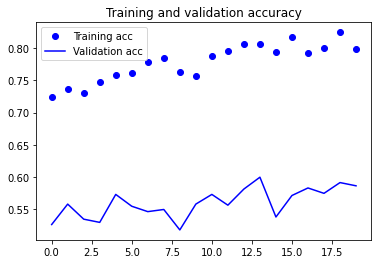

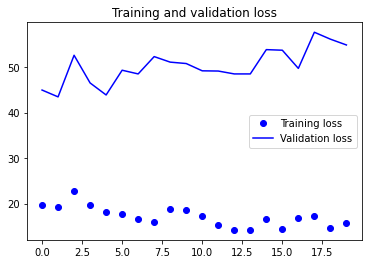

In [ ]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_x = range(len(acc))

plt.plot(epochs_x, acc, 'bo', label='Training acc')
plt.plot(epochs_x, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs_x, loss, 'bo', label='Training loss')
plt.plot(epochs_x, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [ ]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnetb0 (Functional)  (None, 14, 14, 1280)      4049571   
_________________________________________________________________
gap (GlobalMaxPooling2D)     (None, 1280)              0         
_________________________________________________________________
dropout_out (Dropout)        (None, 1280)              0         
_________________________________________________________________
fc_out (Dense)               (None, 200)               256200    
Total params: 4,305,771
Trainable params: 256,200
Non-trainable params: 4,049,571
_________________________________________________________________


## 第二批訓練,unfreez layer,讓整個模型都參與訓練

In [ ]:
def unfreeze_model(model):
    # We unfreeze the top 20 layers while leaving BatchNorm layers frozen
    for layer in model.layers[-20:]:
        if not isinstance(layer, layers.BatchNormalization):
            layer.trainable = True

    optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)
    model.compile(
        optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"]
    )


unfreeze_model(model)
model.summary()


Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnetb0 (Functional)  (None, 14, 14, 1280)      4049571   
_________________________________________________________________
gap (GlobalMaxPooling2D)     (None, 1280)              0         
_________________________________________________________________
dropout_out (Dropout)        (None, 1280)              0         
_________________________________________________________________
fc_out (Dense)               (None, 200)               256200    
Total params: 4,305,771
Trainable params: 4,263,748
Non-trainable params: 42,023
_________________________________________________________________


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')

# Note that the validation data should not be augmented!
test_datagen = ImageDataGenerator()

train_generator = train_datagen.flow_from_directory(
        # This is the target directory
        TRAIN_DIR,
        # All images will be resized to target height and width.
        target_size=(height, width),
        batch_size=8,
        # Since we use categorical_crossentropy loss, we need categorical labels
        class_mode='categorical')

validation_generator = test_datagen.flow_from_directory(
        VALIDATION_DIR,
        target_size=(height, width),
        batch_size=8,
        class_mode='categorical')

Found 2400 images belonging to 200 classes.
Found 600 images belonging to 200 classes.


In [ ]:
history = model.fit(
      train_generator,
      epochs=epochs,
      validation_data=validation_generator,
      verbose=1)


Epoch 1/20
300/300 [==============================] - 205s 671ms/step - loss: 37.4160 - accuracy: 0.5496 - val_loss: 25.9370 - val_accuracy: 0.6300
Epoch 2/20
300/300 [==============================] - 199s 664ms/step - loss: 9.6959 - accuracy: 0.7583 - val_loss: 22.9623 - val_accuracy: 0.6483
Epoch 3/20
300/300 [==============================] - 199s 663ms/step - loss: 6.5617 - accuracy: 0.8058 - val_loss: 22.1073 - val_accuracy: 0.6800
Epoch 4/20
300/300 [==============================] - 201s 668ms/step - loss: 5.3021 - accuracy: 0.8300 - val_loss: 21.1351 - val_accuracy: 0.6517
Epoch 5/20
300/300 [==============================] - 201s 669ms/step - loss: 4.1225 - accuracy: 0.8537 - val_loss: 17.1771 - val_accuracy: 0.6567
Epoch 6/20
300/300 [==============================] - 202s 673ms/step - loss: 3.8533 - accuracy: 0.8529 - val_loss: 16.6591 - val_accuracy: 0.6667
Epoch 7/20
300/300 [==============================] - 203s 676ms/step - loss: 3.3401 - accuracy: 0.8754 - val_loss: 1

In [ ]:
from google.colab import files
model.save('model_v11.h5') 
files.download('model_v11.h5')

/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# 結果

In [ ]:
import os
import numpy as np
import numpy as np
from keras.preprocessing.image import img_to_array, load_img


with open('/content/drive/MyDrive/碩一上/作業/基於深度學習之視覺辨識/HW1/testing_img_order.txt') as f:
     test_images = [x.strip() for x in f.readlines()]  # all the testing images

submission = []
i=0
for img_name in test_images:  # image order is important to your result
  img_path = '/content/drive/MyDrive/碩一上/作業/基於深度學習之視覺辨識/HW1/testing_images/'+img_name
  img = load_img(img_path, target_size=(448, 448))  # this is a PIL image
  x = img_to_array(img)  # Numpy array with shape (150, 150, 3)
  x = x.reshape((1,) + x.shape)  # Numpy array with shape (1, 150, 150, 3)

  result = model.predict(x)
  cn = np.argmax(result,axis=1)
  submission.append([img_name, classes[cn[0]]])
  i +=1
  print(i)
  print([img_name, classes[cn[0]]])

np.savetxt('answer_v11.txt', submission, fmt='%s')
files.download('answer_v11.txt')

串流輸出內容已截斷至最後 5000 行。
534
['1953.jpg', '174.Palm_Warbler']
535
['1358.jpg', '066.Western_Gull']
536
['4924.jpg', '190.Red_cockaded_Woodpecker']
537
['5942.jpg', '153.Philadelphia_Vireo']
538
['2042.jpg', '004.Groove_billed_Ani']
539
['3852.jpg', '002.Laysan_Albatross']
540
['4457.jpg', '054.Blue_Grosbeak']
541
['0234.jpg', '132.White_crowned_Sparrow']
542
['3916.jpg', '139.Scarlet_Tanager']
543
['3026.jpg', '141.Artic_Tern']
544
['3027.jpg', '020.Yellow_breasted_Chat']
545
['3365.jpg', '002.Laysan_Albatross']
546
['4094.jpg', '119.Field_Sparrow']
547
['1340.jpg', '070.Green_Violetear']
548
['4638.jpg', '060.Glaucous_winged_Gull']
549
['5088.jpg', '061.Heermann_Gull']
550
['2146.jpg', '001.Black_footed_Albatross']
551
['0421.jpg', '059.California_Gull']
552
['2241.jpg', '007.Parakeet_Auklet']
553
['3190.jpg', '107.Common_Raven']
554
['5553.jpg', '002.Laysan_Albatross']
555
['0827.jpg', '113.Baird_Sparrow']
556
['1462.jpg', '088.Western_Meadowlark']
557
['3950.jpg', '106.Horned_Puffin']
5

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>